## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---
### Read images and create vehicles and non vehicles arrays

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


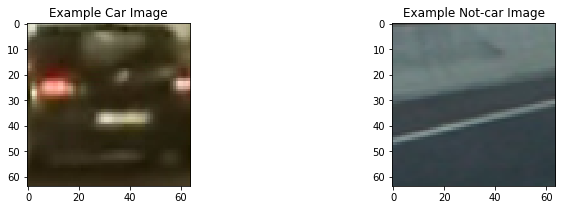

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

# Get all vehicles and non-vehicles images
vehicle_images = glob.glob('vehicles/*/*.png')
non_vehicles_images = glob.glob('non-vehicles/*/*.png')

# Create cars and notcars arrays and load images
cars = []
notcars = []

for car_image in vehicle_images:
    cars.append(car_image)

for notcar_image in non_vehicles_images:
    notcars.append(notcar_image)    

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Create spatial binned, histogram and HOG feature extractor

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    
    # Return the color_stack vector
    return features

In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return channel1_hist, channel2_hist, channel3_hist, bin_centers, hist_features

In [4]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                                  cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = False, 
                                  visualise = vis, feature_vector = feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                       cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = False, 
                       visualise = vis, feature_vector = feature_vec)
        return features

### Test features extraction on a sample image

Vehicle Features


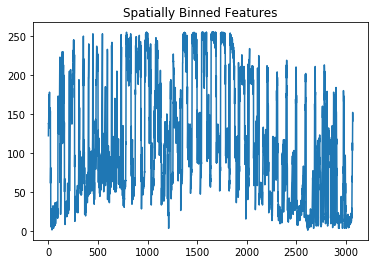

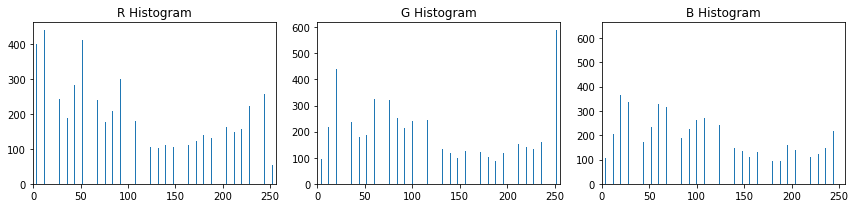

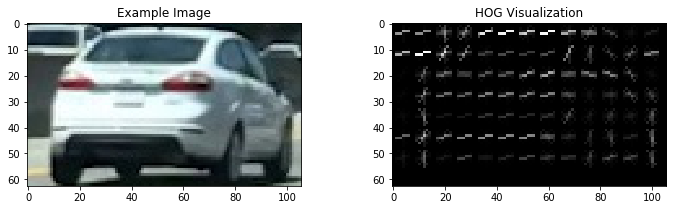

Non Vehicle Features


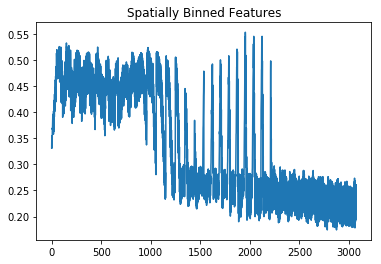

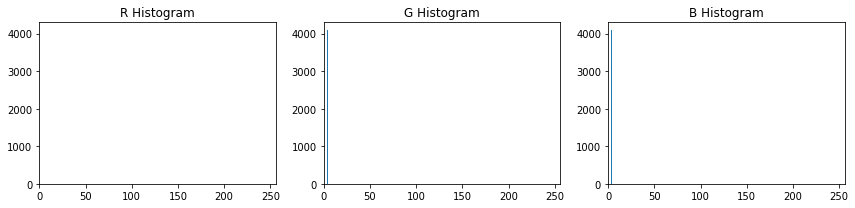

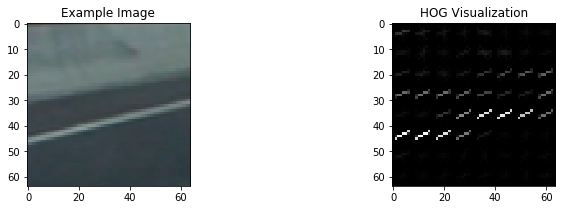

In [5]:
def test_features(image, img_type):
    # Get spatial bin vector 
    bin_spatial_vector = bin_spatial(image, size=(32, 32))

    # Plot features
    plt.plot(bin_spatial_vector)
    plt.title('Spatially Binned Features')

    # Get color histogram 
    rh, gh, bh, bincen, color_vec = color_hist(image, nbins=32, bins_range=(0, 256))

    # Plot a figure with all three bar charts
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()

    # Get Hog Features
    # Convert to Gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define HOG parameters
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2

    # Call with vis=True to see an image output
    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

    # Plot the examples
    if(img_type == "car"):
        print("Vehicle Features")
    else:
        print("Non Vehicle Features")    
    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')
    plt.show()
    
# Read in test image
image = mpimg.imread('test_images/cutout1.jpg')

test_features(image, "car")
test_features(notcar_image, "not_car")

### Perform a Histogram of Oriented Gradients (HOG), Color Transformation, Binned Color and Histograms feature extraction on a labeled training set of images

In [6]:
# Create Feature Extractor
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a list of images
def extract_features(imgs, color_space = 'RGB', spatial_size = (32, 32), hist_bins = 32, 
                     orient = 9, pix_per_cell = 8, cell_per_block = 2, hog_channel = 0,  
                     spatial_feat = True, hist_feat = True, hog_feat = True):
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size = spatial_size)

            # Append features to list
            file_features.append(spatial_features)
            
        # Compute histogram features if flag is set
        if hist_feat == True:
            rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins = hist_bins)

            # Append features to list
            file_features.append(hist_features)
            
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):  
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis = False, feature_vec = True)

            # Append features to list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))

    # Return concatenated array of features
    return features

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features() just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)   
        
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        # Append features to list
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        rh, gh, bh, bincen, hist_features = color_hist(feature_image, nbins=hist_bins)
        
        # Append features to list
        img_features.append(hist_features)
        
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)

In [8]:
# Define function to draw boxes on image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

### Demonstrate Sliding Window Technique

In [9]:
# Define a function that takes an image, start and stop positions in both x and y, window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# This function is not used on the final pipeline. It is only used to demonstrate the windows on a given sample image
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]       
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan - ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
       
    # Return the list of windows
    return window_list

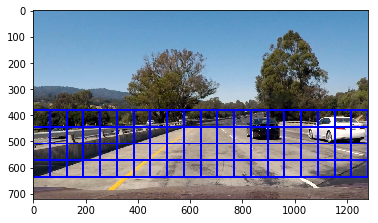

In [10]:
# Read in the sample image
slide_image = mpimg.imread('test_images/test1.jpg')

windows = slide_window(slide_image, x_start_stop=[None, None], y_start_stop=[380, 650], 
                       xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    
window_img = draw_boxes(slide_image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Define Tunning Parameters

In [11]:
# Define function to hold all the tunning parameters used by the classifier and the pipeline
def tunning_parameters():
    ### Classifier parameters ###
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    
    # Hog classifier parameters
    orient = 9
    pix_per_cell = 8 
    cell_per_block = 2 
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    
    # Color histogram/spatial binning classifier parameters
    spatial_size = (32, 32)
    hist_bins = 32 
    
    # Other parameters
    y_start_stop = [380, 650] # Min and max in y to search in find_cars()
    scale = 1.4
    threshold = 4 #4
    
    return color_space, spatial_feat, hist_feat, hog_feat, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, y_start_stop, scale, threshold

### Train a Linear SVM classifier

In [12]:
# Train Classifier

# Reduce the sample size because HOG features are slow to compute
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size] 

# Get parameters
color_space, spatial_feat, hist_feat, hog_feat, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, y_start_stop, scale, threshold = tunning_parameters()

print('Extracting features...')

# Start time
t = time.time()

# Get cars features
car_features = extract_features(cars, color_space = color_space, spatial_size = spatial_size, hist_bins = hist_bins, 
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                hog_channel = hog_channel, spatial_feat = spatial_feat, 
                                hist_feat = hist_feat, hog_feat = hog_feat)

# Get not-cars features
notcar_features = extract_features(notcars, color_space = color_space, spatial_size = spatial_size, hist_bins = hist_bins, 
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, 
                                hog_channel = hog_channel, spatial_feat = spatial_feat, 
                                hist_feat = hist_feat, hog_feat = hog_feat)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell ', cell_per_block, 'cells per block',
     spatial_size, 'spatial bins and', hist_bins, 'histogram bins')
print('Feature vector length:', len(X_train[0]))

print('Training classifier...')

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Extracting features...
113.03 Seconds to extract features...
Using: 9 orientations 8 pixels per cell  2 cells per block (32, 32) spatial bins and 32 histogram bins
Feature vector length: 8460
Training classifier...
29.93 Seconds to train SVC...
Test Accuracy of SVC =  0.9873
My SVC predicts:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.]
0.00285 Seconds to predict 10 labels with SVC


### Implement a sliding-window technique and use the trained classifier to search for vehicles in images

In [13]:
# Define function to apply a color conversion
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [14]:
# Define function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # Get y positions
    ystart = ystart_stop[0]
    ystop = ystart_stop[1]
    
    # An array to store detection boxes
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (128,128))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            rh, gh, bh, bincen, hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                position = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(position)
                
    return bbox_list, draw_img

In [15]:
# Define a function to threshold the heat map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

In [16]:
# Define function to draw bounding boxes around the labeled regions
def get_labeled_bboxes(img, labels):
    boxes = []
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        boxes.append(bbox)
        
    # Return the image
    return boxes

### Apply a sample pipeline to a sample image to verify functionality

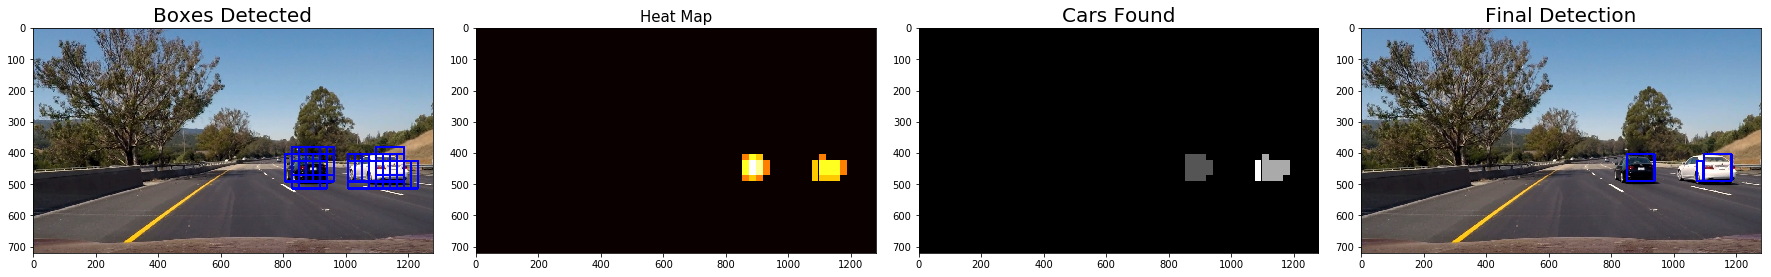

In [17]:
from scipy.ndimage.measurements import label

# Test sample pipeline

# Read in image similar to one shown above 
image = mpimg.imread('test_images/test6.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Get tunning parameters
color_space, spatial_feat, hist_feat, hog_feat, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, y_start_stop, scale, threshold = tunning_parameters()

bbox_list, pos_img = find_cars(image, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

# Add heat to each box in box list
#adds "heat" to a map for a list of bounding boxes
for box in bbox_list:
    # Add += 1 for all pixels inside each bbox
    # Assuming each "box" takes the form ((x1, y1), (x2, y2))
    heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
boxes = get_labeled_bboxes(np.copy(image), labels)

draw_img = draw_boxes(image, boxes)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(pos_img)
ax1.set_title('Boxes Detected', fontsize=20)

ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=15)

ax3.imshow(labels[0], cmap='gray')
ax3.set_title('Cars Found', fontsize=20)

ax4.imshow(draw_img)
ax4.set_title('Final Detection', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Create pipeline where a heat map of recurring detections frame by frame is created to reject outliers and follow detected vehicles as well as an estimation of bounding box for vehicles detected

In [18]:
# Image Processing Pipeline

# Initialize arrays that will be used to keep track of the found detections
previous_detections = []

def process_image(image):
    
    global previous_detections

    # Get tunning parameters
    color_space, spatial_feat, hist_feat, hog_feat, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, y_start_stop, scale, threshold = tunning_parameters()
    
    # Detecting vehicles using raw image data and HOG features
    vehicle_detections, pos_img = find_cars(image, y_start_stop, 
                                   scale, svc, X_scaler, 
                                   orient, pix_per_cell, cell_per_block, 
                                   spatial_size, hist_bins)
    
    # Updating previous frames' detections with new frame, and removing frames that are too old
    previous_detections.append(vehicle_detections)
    previous_detections = previous_detections[-10:]

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    #heat = add_heat(heat,previous_detections)
    for frame in previous_detections:
        for window in frame:
            heat[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    boxes = get_labeled_bboxes(np.copy(image), labels)
    

     #draw heated map on video 
    new_blank = cv2.resize(heatmap, (266, 150))
    new_labels = np.dstack((new_blank*20, new_blank, new_blank))
    
    
    x_offset=y_offset=50
    final_img = draw_boxes(image, boxes)
    
    #draw heated map on video 
    final_img[y_offset:y_offset+new_labels.shape[0], x_offset:x_offset+new_labels.shape[1]] = new_labels

    # Draw the boxes on original image
    return final_img

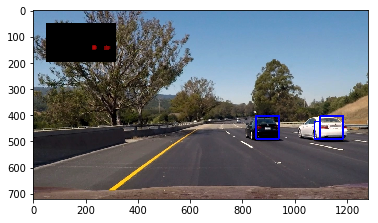

In [19]:
# Test pipeline on a sample image
# Reitinialize previous_detections array
previous_detections = []
plt.imshow(process_image(mpimg.imread('test_images/test6.jpg')))

### Run pipeline on a video stream

In [20]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Reitinialize previous_detections array
previous_detections = []

# Set up lines for left and right
white_output = 'project_results_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_results_video.mp4
[MoviePy] Writing video project_results_video.mp4


100%|█████████▉| 1260/1261 [19:03<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_results_video.mp4 

CPU times: user 19min 58s, sys: 5.79 s, total: 20min 4s
Wall time: 19min 4s
